# Setup

In [ ]:
!git clone -b develop https://github.com/StarkitRobots/cvr_course

In [ ]:
cd cvr_course/notebooks

# Stereo pair calibration

- Intrinsic_mtx_1 - матрица 1 камеры
- dist_1 - коэффициенты дисторсии 1 камеры
- Intrinsic_mtx_2 - матрица 2 камеры
- dist_2 - коэффициенты дисторсии 2 камеры

- R - матрица поворота между камерами
- T - матрица трансляции между камерами

https://github.com/bvnayak/stereo_calibration.git

In [1]:
import numpy as np
import cv2
import glob
import argparse

class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9*7, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:7].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        images_right = glob.glob(cal_path + 'right*.png')
        images_left = glob.glob(cal_path + 'left*.png')
        images_left.sort()
        images_right.sort()

        print ("images_left", images_left, images_right)

        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(gray_l, (9, 7), None)
            ret_r, corners_r = cv2.findChessboardCorners(gray_r, (9, 7), None)

            # If found, add object points, image points (after refining them)
            self.objpoints.append(self.objp)

            if ret_l is True:
                rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(img_l, (9, 7),
                                                  corners_l, ret_l)
                #cv2.imshow(images_left[i], img_l)
                cv2.waitKey(500)

            if ret_r is True:
                rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(img_r, (9, 7),
                                                  corners_r, ret_r)
                #cv2.imshow(images_right[i], img_r)
                cv2.waitKey(100)
            img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None)
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None)

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5

        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.imgpoints_l,
            self.imgpoints_r, self.M1, self.d1, self.M2,
            self.d2, dims,
            criteria=stereocalib_criteria, flags=flags)

        print('Intrinsic_mtx_1', M1)
        print('dist_1', d1)
        print('Intrinsic_mtx_2', M2)
        print('dist_2', d2)
        print('R', R)
        print('T', T)
        print('E', E)
        print('F', F)

        # for i in range(len(self.r1)):
        #     print("--- pose[", i+1, "] ---")
        #     self.ext1, _ = cv2.Rodrigues(self.r1[i])
        #     self.ext2, _ = cv2.Rodrigues(self.r2[i])
        #     print('Ext1', self.ext1)
        #     print('Ext2', self.ext2)

        print('')

        camera_model = dict([('M1', M1), ('M2', M2), ('dist1', d1),
                            ('dist2', d2), ('rvecs1', self.r1),
                            ('rvecs2', self.r2), ('R', R), ('T', T),
                            ('E', E), ('F', F)])

        cv2.destroyAllWindows()
        return camera_model

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('filepath', help='String Filepath')
#     args = parser.parse_args()
#     cal_data = StereoCalibration(args.filepath)


In [2]:
#from stereo_calibration.camera_calibrate import StereoCalibration
cal = StereoCalibration('../data/imgs/calibrationdat/')
cal.camera_model

images_left ['../data/imgs/calibrationdat/left-0000.png', '../data/imgs/calibrationdat/left-0001.png', '../data/imgs/calibrationdat/left-0002.png', '../data/imgs/calibrationdat/left-0003.png', '../data/imgs/calibrationdat/left-0004.png', '../data/imgs/calibrationdat/left-0005.png', '../data/imgs/calibrationdat/left-0006.png', '../data/imgs/calibrationdat/left-0007.png'] ['../data/imgs/calibrationdat/right-0000.png', '../data/imgs/calibrationdat/right-0001.png', '../data/imgs/calibrationdat/right-0002.png', '../data/imgs/calibrationdat/right-0003.png', '../data/imgs/calibrationdat/right-0004.png', '../data/imgs/calibrationdat/right-0005.png', '../data/imgs/calibrationdat/right-0006.png', '../data/imgs/calibrationdat/right-0007.png']
Intrinsic_mtx_1 [[528.92971096   0.         331.42886362]
 [  0.         527.52644974 226.75469671]
 [  0.           0.           1.        ]]
dist_1 [[-2.11291512e-02  3.86518866e-01 -9.74649753e-05 -8.04617066e-03
  -1.07309518e+00]]
Intrinsic_mtx_2 [[540.

{'M1': array([[528.92971096,   0.        , 331.42886362],
        [  0.        , 527.52644974, 226.75469671],
        [  0.        ,   0.        ,   1.        ]]),
 'M2': array([[540.64064893,   0.        , 305.72908381],
        [  0.        , 538.78102068, 224.08418785],
        [  0.        ,   0.        ,   1.        ]]),
 'dist1': array([[-2.11291512e-02,  3.86518866e-01, -9.74649753e-05,
         -8.04617066e-03, -1.07309518e+00]]),
 'dist2': array([[ 0.01986216, -0.01022643,  0.00145098, -0.0073049 , -0.035019  ]]),
 'rvecs1': (array([[-0.1636584 ],
         [ 0.70498388],
         [ 2.76465316]]),
  array([[-0.12892797],
         [ 0.69493352],
         [ 2.94123178]]),
  array([[-0.32698814],
         [-0.00034848],
         [ 0.01013225]]),
  array([[-0.10304573],
         [-0.45069216],
         [-3.09902395]]),
  array([[-0.13741482],
         [-0.41571386],
         [-3.11173667]]),
  array([[-0.23186588],
         [ 0.09767764],
         [ 0.07059253]]),
  array([[-0.4836

# Disparity map obtainment

https://github.com/OmarPadierna/3DReconstruction

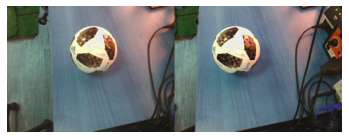

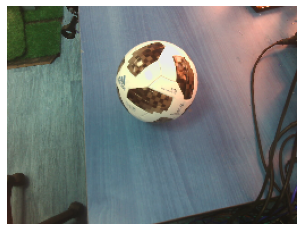

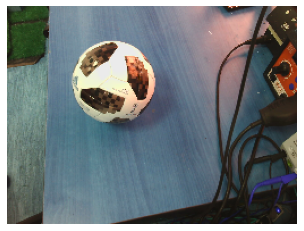


Computing the disparity  map...


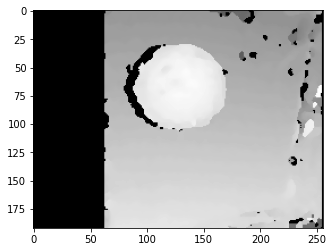

In [3]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

#=====================================
# Function declarations
#=====================================

#Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image


img = cv2.imread ("../data/imgs/stereopairs/sp2.jpg")

plt.imshow (img)
plt.axis ('off')
plt.show ()

img_downsampled = cv2.resize (img, (512, 192))

img_1_downsampled = img_downsampled [:, :256, :]
img_2_downsampled = img_downsampled [:, 256:, :]

plt.imshow (img_1_downsampled)
plt.axis ('off')
plt.show ()

plt.imshow (img_2_downsampled)
plt.axis ('off')
plt.show ()

#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5,
	uniquenessRatio = 5,
	speckleWindowSize = 5,
	speckleRange = 5,
	disp12MaxDiff = 2,
	P1 = 8*3*win_size**2,#8*3*win_size**2,
	P2 =32*3*win_size**2) #32*3*win_size**2)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

# Point cloud generation

In [5]:
#Generate point cloud. 
print ("\nGenerating the 3D map...")

#Get new downsampled width and height 
h,w = img_2_downsampled.shape[:2]

#Load focal length. 
#focal_length = np.load('./camera_params/FocalLength.npy')
focal_length = 517

#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
# Q = np.float32([[1,0,0,-w/2.0],
# 				[0,-1,0,h/2.0],
# 				[0,0,0,-focal_length],
# 				[0,0,1,0]])

#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
# Q2 = np.float32([[1,0,0,0],
# 				[0,-1,0,0],
# 				[0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
# 				[0,0,0,1]])

M1 = cal.camera_model ["M1"]
M2 = cal.camera_model ["M1"]
D1 = cal.camera_model ["dist1"]
D2 = cal.camera_model ["dist2"]
R = cal.camera_model ["R"]
T = cal.camera_model ["T"]

R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(M1, D1,
    M2, D2, (h, w), R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.9)

print ("Q", Q)

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

#Get color points
colors = cv2.cvtColor(img_1_downsampled, cv2.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

#Define name for output file
#output_file = 'reconstructed.ply'

#Generate point cloud 
#print ("\n Creating the output file... \n")
#create_output(output_points, output_colors, output_file)

print (output_points)
print (len (output_points))


Generating the 3D map...
Q [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -4.05860682e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.34690853e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.91025368e+02]
 [ 0.00000000e+00  0.00000000e+00  3.48529545e-01 -0.00000000e+00]]
[[-2.3923554  -1.6423764   2.7364118 ]
 [-2.5012698  -1.722185    2.8693833 ]
 [-2.4939318  -1.722185    2.8693833 ]
 ...
 [-1.6040645  -0.4525548   4.050285  ]
 [-1.5544249  -0.44140026  3.9504538 ]
 [-1.544322   -0.44140026  3.9504538 ]]
35715


In [6]:
import numpy as np
import open3d

def vis (X, color = np.array([0,0,1], dtype='float64')):
    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(X)
    pcd.paint_uniform_color(color)
    open3d.visualization.draw_geometries([pcd])

vis(output_points, np.array([0,0,1], dtype='float64'))

In [1]:
import numpy as np
import cv2
import time
import math
import copy
import matplotlib.pyplot as plt

axes = {"x" : 0, "y" : 1, "z" : 2}

class Figure:
    def __init__(self):
        pass
    
    def draw(self, canvas, emitter):
        pass
    
    def move(self):
        pass

class Light_emitter:
    def __init__(self, x0, y0, z0, color):
        self.x = x0
        self.y = y0
        self.z = z0
        self.color = color
        
    def get_coords(self):
        return np.array([self.x, self.y, self.z], np.float64)
    
    def get_color(self):
        return self.color

class Circle(Figure):
    def __init__(self, x0, y0, z0, r, color):
        Figure.__init__(self)
        self.x = x0
        self.y = y0
        self.z = z0
        
        self.r = r
        self.color = color
        
    def draw(self, canvas, emitter):
        canvas.draw_3d_circle((self.x, self.y, self.z), self.r, self.color)
    
    def move(self):
        self.z += 0.1

class Line(Figure):
    def __init__(self, x10, y10, z10, x20, y20, z20, color):
        Figure.__init__(self)
        self.x1 = x10
        self.y1 = y10
        self.z1 = z10
        self.x2 = x20
        self.y2 = y20
        self.z2 = z20
        
        self.color = color
        
    def draw(self, canvas, emitter):
        canvas.draw_3d_line((self.x1, self.y1, self.z1), (self.x2, self.y2, self.z2), self.color)
    
    def move(self):
        self.z1 += 0.1
        self.z2 += 0.04

class Triangle(Figure):
    def __init__(self, p1, p2, p3, color):
        self.p1 = np.array(p1, np.float64)
        self.p2 = np.array(p2, np.float64)
        self.p3 = np.array(p3, np.float64)
        
        self.color      = color
        self.curr_color = self.color
    
    def draw(self, canvas, emitter, shift = np.zeros((3), np.float64)):
        self.calc_lighting(emitter, shift)
        
        canvas.draw_3d_triangle(self.p1, self.p2, self.p3, self.curr_color, shift)
    
    def get_midpoint(self):
        return (self.p1 + self.p2 + self.p3) / 3
    
    def calc_lighting(self, emitter, shift):
        # normal vector calculation
        A = self.p2 - self.p1
        B = self.p3 - self.p1
        
        Nx = A[1] * B[2] - A[2] * B[1]
        Ny = A[2] * B[0] - A[0] * B[2]
        Nz = A[0] * B[1] - A[1] * B[0]
        
        N = np.array([Nx, Ny, Nz], np.float64)
        l_N = np.linalg.norm(N)
        
        #print(N)
        #print(l_N)
        
        N /= l_N
        
        # vector from triangle to emitter
        from_tr_to_em = emitter.get_coords() - self.get_midpoint() - shift
        l_ftr = np.linalg.norm(from_tr_to_em)
        from_tr_to_em /= l_ftr
        
        # lighting calculation
        cosine = np.dot(N, from_tr_to_em)
        
        #print(cosine)
        
        lighting = max(0, cosine)
        
        em_color = emitter.get_color()
        
        self.curr_color = (self.color[0] * em_color[0] / 255 * lighting,
                           self.color[1] * em_color[1] / 255 * lighting,
                           self.color[2] * em_color[2] / 255 * lighting)
        
        #print(self.curr_color)
        
    def _rotate_point(self, p, theta, axis = "x"):
        rot_mat = np.array([[math.cos(theta), -math.sin(theta)],
                        [math.sin(theta), math.cos(theta)]])
        
        vec = np.zeros((2), np.float64)
        
        ind = 0
        
        for i in range(3):
            if (i != axes[axis]):
                vec[ind] = p[i]
                ind += 1
        
        rotated = np.dot(rot_mat, vec)
        
        ind = 0
        
        for i in range(3):
            if (i != axes[axis]):
                p[i] = rotated[ind]
                ind += 1
        
        return p

    def rotate(self, theta, axis):
        self.p1 = self._rotate_point(self.p1, theta, axis)
        self.p2 = self._rotate_point(self.p2, theta, axis)
        self.p3 = self._rotate_point(self.p3, theta, axis)
    
    #def move(self):
    #    self.rotate(0.12, "x")

class Triangle_mesh(Figure):
    def __init__(self, center, rot_vel = {}):
        Figure.__init__(self)
        
        self.triangles = []
        
        self.center = np.array(center, np.float64)
        
        self.rot_vel = rot_vel
    
    def add_triangle(self, new_triangle):
        self.triangles.append(new_triangle)
    
    def generate_triangulation(self):
        pass
    
    def draw(self, canvas, emitter):
        for tr in sorted(self.triangles, key = lambda tr: - tr.get_midpoint()[2]):
            tr.draw(canvas, emitter, self.center)
    
    def rotate(self, theta, axis):
        for tr in self.triangles:
            tr.rotate(theta, axis)
    
    def move(self):
        for k, v in self.rot_vel.items():
            self.rotate(v, k)

class Two_dim_func(Triangle_mesh):
    def __init__(self, center, w, h, color, pnum, z0, func):
        Triangle_mesh.__init__(self, center)
        
        self.w = w
        self.h = h
        
        self.color = color
        self.pnum  = pnum
        
        self.z0 = z0
        
        self.func = func
        
        self.generate_triangulation()
        
    def generate_triangulation(self):
        xvals = np.linspace(- self.w / 2, self.w / 2, self.pnum)
        yvals = np.linspace(- self.h / 2, self.h / 2, self.pnum)
        
        for i in range(self.pnum - 1):
            for j in range(self.pnum - 1):
                p1 = (xvals[i], yvals[j], self.z0 + self.func(xvals[i], yvals[j]))
                p2 = (xvals[i], yvals[j + 1], self.z0 + self.func(xvals[i], yvals[j + 1]))
                p3 = (xvals[i + 1], yvals[j], self.z0 + self.func(xvals[i + 1], yvals[j]))
                p4 = (xvals[i + 1], yvals[j + 1], self.z0 + self.func(xvals[i + 1], yvals[j + 1]))
                
                self.add_triangle(Triangle(p1, p3, p2, self.color))
                self.add_triangle(Triangle(p2, p3, p4, self.color))

class Cylinder(Triangle_mesh):
    def __init__(self, center, r, h, color, pnum, rot_vel):
        Triangle_mesh.__init__(self, center, rot_vel)
        
        self.r = r
        self.h = h
        
        self.color = color
        self.pnum  = pnum
                
        self.generate_triangulation()
        
    def generate_triangulation(self):
        yvals = np.linspace(0, self.h, self.pnum)
        avals = np.linspace(0, 2 * math.pi, self.pnum)
        
        for i in range(self.pnum - 1):
            for j in range(self.pnum - 1):
                p1 = (self.r * math.cos(avals[i]), yvals[j], self.r * math.sin(avals[i]))
                p2 = (self.r * math.cos(avals[i]), yvals[j + 1], self.r * math.sin(avals[i]))
                p3 = (self.r * math.cos(avals[i + 1]), yvals[j], self.r * math.sin(avals[i + 1]))
                p4 = (self.r * math.cos(avals[i + 1]), yvals[j + 1], self.r * math.sin(avals[i + 1]))
                
                self.add_triangle(Triangle(p1, p2, p3, self.color))
                self.add_triangle(Triangle(p2, p4, p3, self.color))

class Ellipsoid(Triangle_mesh):
    def __init__(self, center, r, h, color, pnum, rot_vel):
        Triangle_mesh.__init__(self, center, rot_vel)
        
        self.r = r
        self.h = h
        
        self.color = color
        self.pnum  = pnum
                
        self.generate_triangulation()
    
    def _rand_color(self):
        return (np.random.randint(255), np.random.randint(255), np.random.randint(255))
    
    def generate_triangulation(self):
        yvals = np.linspace(- self.h, self.h, self.pnum)
        avals = np.linspace(0, 2 * math.pi, self.pnum)
        
        for i in range(self.pnum - 1):
            for j in range(self.pnum - 1):
                r_curr = math.sqrt(self.h**2 - yvals[j]**2) * self.r / self.h
                r_next = math.sqrt(self.h**2 - yvals[j + 1]**2) * self.r / self.h
                
                p1 = (r_curr * math.cos(avals[i]),     yvals[j],     r_curr * math.sin(avals[i]))
                p2 = (r_next * math.cos(avals[i]),     yvals[j + 1], r_next * math.sin(avals[i]))
                p3 = (r_curr * math.cos(avals[i + 1]), yvals[j],     r_curr * math.sin(avals[i + 1]))
                p4 = (r_next * math.cos(avals[i + 1]), yvals[j + 1], r_next * math.sin(avals[i + 1]))
                
                if (j != 0):
                    self.add_triangle(Triangle(p1, p2, p3, self._rand_color()))
                
                if (j != self.pnum - 2):
                    self.add_triangle(Triangle(p2, p4, p3, self._rand_color()))

class Radially_symmetrical_obj(Triangle_mesh):
    def __init__(self, center, h, color, pnum, rot_vel, func):
        Triangle_mesh.__init__(self, center, rot_vel)
        
        self.h = h
        
        self.color = color
        self.pnum  = pnum
        
        self.func = func
                
        self.generate_triangulation()
    
    def _rand_color(self):
        return (np.random.randint(255), np.random.randint(255), np.random.randint(255))
    
    def generate_triangulation(self):
        yvals = np.linspace(- self.h, self.h, self.pnum)
        avals = np.linspace(0, 2 * math.pi, self.pnum)
        
        for i in range(self.pnum - 1):
            for j in range(self.pnum - 1):
                r_curr = self.func(yvals[j] / self.h) * self.h
                r_next = self.func(yvals[j + 1] / self.h) * self.h
                
                p1 = (r_curr * math.cos(avals[i]),     yvals[j],     r_curr * math.sin(avals[i]))
                p2 = (r_next * math.cos(avals[i]),     yvals[j + 1], r_next * math.sin(avals[i]))
                p3 = (r_curr * math.cos(avals[i + 1]), yvals[j],     r_curr * math.sin(avals[i + 1]))
                p4 = (r_next * math.cos(avals[i + 1]), yvals[j + 1], r_next * math.sin(avals[i + 1]))
                
                if (j != 0):
                    self.add_triangle(Triangle(p1, p2, p3, self._rand_color()))
                
                if (j != self.pnum - 2):
                    self.add_triangle(Triangle(p2, p4, p3, self._rand_color()))

# szx - width of the whole "world"
# center (0, 0) is in WIND_X // 2, WIND_Y // 2

class Canvas:
    def __init__(self, WIND_X, WIND_Y, color, szx, szy, szz = 1, name = "canvas"):
        self.WIND_X = WIND_X
        self.WIND_Y = WIND_Y
        
        self.szx = szx
        self.szy = szy
        self.szz = szz
        
        self.color = color
        self.name = name
        
        self.canvas = np.zeros((WIND_Y, WIND_X, 3), np.uint8)
        
        self.clear_canvas()
        
    def clear_canvas(self):
        self.canvas[:, :, 0] = self.color[0]
        self.canvas[:, :, 1] = self.color[1]
        self.canvas[:, :, 2] = self.color[2]
        
    def draw_canvas(self):
        cv2.imshow(self.name, self.canvas)
    
    def project_point(self, p3d):
        x, y, z = p3d
        
        x2d = ((x / self.szx / z + 0.5) * WIND_X)
        y2d = ((y / self.szy / z + 0.5) * WIND_Y)
        
        return x2d, y2d
    
    def draw_3d_circle(self, p3d, r, color):
        xc, yc = self.project_point(p3d)
        
        cv2.circle(self.canvas, (int(xc), int(yc)), int(r / p3d[2]), color, 3)
    
    def draw_3d_line(self, p1, p2, color, th = 1):
        x1, y1 = self.project_point(p1)
        x2, y2 = self.project_point(p2)
        
        cv2.line(self.canvas, (int(x1), int(y1)), (int(x2), int(y2)), color, th)
        
    def draw_3d_triangle(self, p1, p2, p3, color, shift, th = -1):
        x1, y1 = self.project_point(p1 + shift)
        x2, y2 = self.project_point(p2 + shift)
        x3, y3 = self.project_point(p3 + shift)
        
        contours = [np.array([[x1, y1], [x2, y2], [x3, y3]], np.int32)]
        
        cv2.fillPoly(self.canvas, contours, color)

class Manager:
    def __init__(self, WIND_X, WIND_Y, color, szx, szy):
        self.canvas = Canvas(WIND_X, WIND_Y, color, szx, szy)
        self.emitter = Light_emitter(0, -3, 0, (255, 255, 255))
        
        self.exit_flag = False
        
        self.objects = []
    
    def add_object(self, new_object):
        self.objects.append(new_object)
    
    def draw(self):
        self.canvas.clear_canvas()
        
        for obj in self.objects:
            obj.draw(self.canvas, self.emitter)
        
        self.canvas.draw_canvas()
    
    def move(self):
        for obj in self.objects:
            obj.move()
        
    def handle_keyboard(self):
        key = cv2.waitKey(100) & 0xFF
    
        if (key == ord('q')):
            self.exit_flag = True
        
    def exit(self):
        return self.exit_flag

class Randomized_surface(Triangle_mesh):
    def __init__(self, center, w, h, color, pnum, z0, rot_vel = {}):
        Triangle_mesh.__init__(self, center, rot_vel)
        
        self.w = w
        self.h = h
        
        self.color = color
        self.pnum  = pnum
        
        self.z0 = z0
        
        self.generate_triangulation()
        
    def generate_triangulation(self):
        xvals = np.linspace(- self.w / 2, self.w / 2, self.pnum)
        yvals = np.linspace(- self.h / 2, self.h / 2, self.pnum)
        
        heights = np.zeros((self.pnum, self.pnum), np.float64)
        
        for i in range(int(self.pnum)):
            for j in range(int(self.pnum)):
                heights[i, j] = max((self.pnum / 2 - min(i, self.pnum - i)) / 25,
                                    (self.pnum / 2 - min(j, self.pnum - j)) / 25)

        for k in range(int(math.log2(self.pnum))):
            step = 2**k
            
            print(step)
            
            for i in range(int(self.pnum / step)):
                for j in range(int(self.pnum / step)):
                    heights[int(i * step) : int((i + 1) * step),
                            int(j * step) : int((j + 1) * step)] += np.random.rand() / 3 * math.sqrt(k)
        
        heights = cv2.blur(heights, (3, 3))

        for i in range(self.pnum - 1):
            for j in range(self.pnum - 1):
                p1 = (xvals[i],     yvals[j],     self.z0 + heights[i, j])
                p2 = (xvals[i],     yvals[j + 1], self.z0 + heights[i, j + 1])
                p3 = (xvals[i + 1], yvals[j],     self.z0 + heights[i + 1, j])
                p4 = (xvals[i + 1], yvals[j + 1], self.z0 + heights[i + 1, j + 1])
                
                self.add_triangle(Triangle(p1, p2, p3, self.color))
                self.add_triangle(Triangle(p2, p4, p3, self.color))

color = (60, 60, 60)
WIND_X, WIND_Y = 1000, 700

manager = Manager(WIND_X, WIND_Y, color, 3, 2.25)

#manager.add_object(Circle(1, 1, 2, 50, (10, 230, 120)))
#manager.add_object(Circle(1, -1, 2, 50, (10, 230, 120)))
#manager.add_object(Circle(-1, 1, 2, 50, (10, 230, 120)))
#manager.add_object(Circle(-1, -1, 2, 50, (10, 230, 120)))

#manager.add_object(Line(-1, -1, 1, 2, 3, 1, (10, 230, 120)))

# tr1 = Triangle([-2, -1, 1], [-2, 0, 1], [-1, -1, 1], (10, 230, 120))
# tr2 = Triangle([-1, -1, 1], [-1, 1, 1], [1, -0.5, 1], (210, 20, 12))

# tr_mesh = Triangle_mesh((1, 1, 3))

# tr_mesh.add_triangle(tr1)
# tr_mesh.add_triangle(tr2)

# def two_dim_func(x, y):
#     return (x**2 + 1.5 * y**2) / 12

# plane = Two_dim_func((2, 1.4, 3), 4.4, 4.4, (230, 120, 180), 25, 0, two_dim_func)

# cylinder = Cylinder((0.1, 0.3, 4), 1.7, 2.2, (230, 120, 180), 25,
#                     rot_vel = {"x" : 0.13, "y" : 0.15, "z" : 0.17})

# sphere = Sphere((0.1, 0.3, 10), 5.7, 3, (230, 120, 180), 25,
#                     rot_vel = {"x" : 0.03, "y" : 0.05, "z" : 0.07})

#1
#rand_surf = Randomized_surface((0, 0.0, 5), 6.4, 6.4, (18, 220, 225), 64, 0,
#                               rot_vel = {"y" : 0.03})

#rand_surf.rotate(- math.pi / 2, "x")

#manager.add_object(rand_surf)

def profile(y):
    result = math.sqrt(1 - y**2) * (0.2 * math.sin(10 * y) + 0.5)
    #result = math.sqrt(1 - y**2)
    
    return result

#2
symm = Radially_symmetrical_obj((0.1, 0.3, 10), 5.7, (230, 120, 180), 25,
                    rot_vel = {"x" : 0.03, "y" : 0.05, "z" : 0.07}, func = profile)

manager.add_object(symm)

while(not manager.exit()):
    manager.draw()
    manager.move()
    
    manager.handle_keyboard()

cv2.destroyAllWindows()
cv2.waitKey(10)

-1

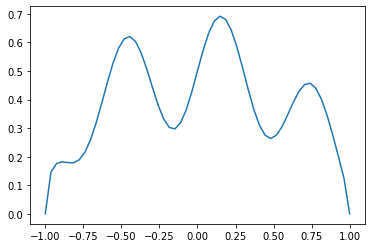

In [2]:
params = np.linspace(-1, 1, 55)

plt.plot(params, [profile(y) for y in params])
plt.show()